#### Load the SQLLite in memory

In [1]:
#1. - Load libraries
import sqlite3
import pandas as pd

In [2]:
# 2.- Create your connection.
connection = sqlite3.connect("home-assistant_v2.db")


# 3.- Query and print all the tables in the database engine
query = """ 
SELECT entity_id, state 
FROM states
"""
result = connection.execute(query).fetchall()
print(result[0:5])

[('sensor.pi_hole_ads_percentage_blocked_today', '25.89'), ('sensor.basement_bed_pht_humidity', '67.5'), ('sensor.basement_bed_pht_humidity', '67.3'), ('sensor.basement_bed_pht_humidity', '67.2'), ('sensor.basement_bed_pht_humidity', '67.3')]


#### Load into a Dataframe

In [3]:
query = """ 
SELECT entity_id, state 
FROM states
"""
df_states = pd.read_sql_query(query, connection)
print(df_states.head(2))

                                     entity_id  state
0  sensor.pi_hole_ads_percentage_blocked_today  25.89
1             sensor.basement_bed_pht_humidity   67.5


## Home Assistant data analysis

### Process function

In [4]:
def process_ha_sensor(df_input: pd.DataFrame, date_col, value_col, value_column_type="numeric", resample=True, resample_aggregate_mode="mean", interpolate=True, resample_time="2h", plot_process=False):
    df_sensor = df_input.copy()
    # Filtering out unavailable strings
    df_sensor = df_sensor[~df_sensor[value_col].str.contains("unavailable")]
    # Converting
    if value_column_type == "numeric":
        df_sensor[value_col] = pd.to_numeric(df_sensor[value_col])
    elif value_column_type == "string":
        df_sensor[value_col] = df_sensor[value_col].astype(str)
    else:
        pass
    df_sensor[date_col] = pd.to_datetime(df_sensor[date_col])
    df_sensor = df_sensor.set_index(date_col)
    if resample:
        df_sensor = df_sensor.resample(resample_time).aggregate(resample_aggregate_mode)
        if plot_process:
            df_sensor.plot()
    if interpolate:
        df_sensor = df_sensor.interpolate(method="linear")
        if plot_process:
            df_sensor.plot()
    return df_sensor

### Process temperature sensor example

In [5]:
# Load only temperature value
query = """ 
SELECT last_updated, entity_id, state
FROM states
WHERE entity_id = 'sensor.basement_bed_pht_temperature'
"""
df_temperature_draft = pd.read_sql_query(query, connection)
print(df_states.head(2))

                                     entity_id  state
0  sensor.pi_hole_ads_percentage_blocked_today  25.89
1             sensor.basement_bed_pht_humidity   67.5


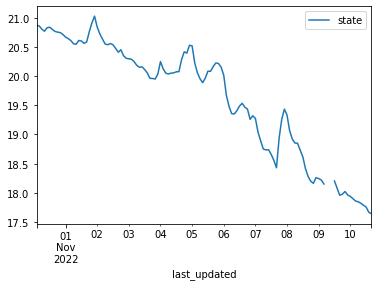

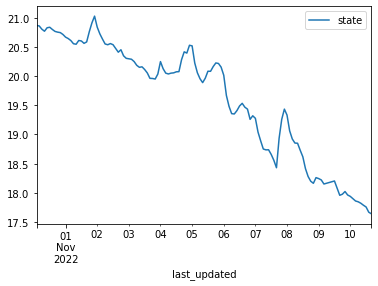

In [6]:
# Home assistant don't use NaN but instead use the "unavailable" human like string. 
# The concept does not change, we need to filter them out
df_temperature_draft = df_temperature_draft[["last_updated", "state"]]
df_temperature_processed = process_ha_sensor(df_temperature_draft, date_col="last_updated", value_col="state", plot_process=True)

### Correlating sensors measurements

In [7]:
# Loading the basement sensors
date_column = "last_updated"
value_column = "temp_value"

query = """ 
SELECT last_updated, entity_id, state
FROM states
WHERE entity_id = 'sensor.basement_bed_pht_temperature'
"""
df_temperature = pd.read_sql_query(query, connection)
df_temperature = df_temperature.rename(columns={"state": value_column})
df_temperature_processed = process_ha_sensor(df_temperature, date_col=date_column, value_col=value_column, plot_process=False)
print(f"Temperature:\n {df_temperature_processed.head(2)}\n")


date_column = "last_updated"
value_column = "humid_value"
query = """ 
SELECT last_updated, entity_id, state
FROM states
WHERE entity_id = 'sensor.basement_bed_pht_humidity'
"""
df_humidity = pd.read_sql_query(query, connection)
df_humidity = df_humidity.rename(columns={"state": value_column})
df_humidity_processed = process_ha_sensor(df_humidity, date_col=date_column, value_col=value_column, plot_process=False)
print(f"Humidity:\n {df_humidity_processed.head(2)}\n")


date_column = "last_updated"
value_column = "outside_temp_value"
query = """ 
SELECT last_updated, entity_id, state
FROM states
WHERE entity_id = 'sensor.openweathermap_temperature'
"""
df_outside_temp = pd.read_sql_query(query, connection)
df_outside_temp = df_outside_temp.rename(columns={"state": value_column})
df_outside_temp = process_ha_sensor(df_outside_temp, date_col=date_column, value_col=value_column, plot_process=False)
print(f"Outside temp:\n {df_humidity_processed.head(2)}\n")


# Merge the sensors
df_temp_humid_processed = df_temperature_processed.join(df_humidity_processed).join(df_outside_temp)
print(df_temp_humid_processed.head())

Temperature:
                      temp_value
last_updated                   
2022-10-31 02:00:00   20.865600
2022-10-31 04:00:00   20.857194

Humidity:
                      humid_value
last_updated                    
2022-10-31 02:00:00    67.195745
2022-10-31 04:00:00    67.168210

Outside temp:
                      humid_value
last_updated                    
2022-10-31 02:00:00    67.195745
2022-10-31 04:00:00    67.168210

                     temp_value  humid_value  outside_temp_value
last_updated                                                    
2022-10-31 02:00:00   20.865600    67.195745           15.115000
2022-10-31 04:00:00   20.857194    67.168210           15.406667
2022-10-31 06:00:00   20.801852    66.876503           15.741250
2022-10-31 08:00:00   20.766777    67.151379           19.498333
2022-10-31 10:00:00   20.826172    67.417627           22.074167


##### Observation
In a season transition like october-november we can see that outside temperature is not impacting so much on inside temperature in intra-day time

In the long run we see a progressive decrease in temperature

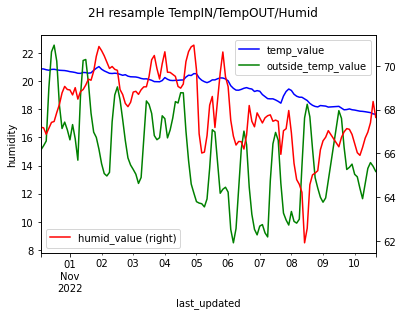

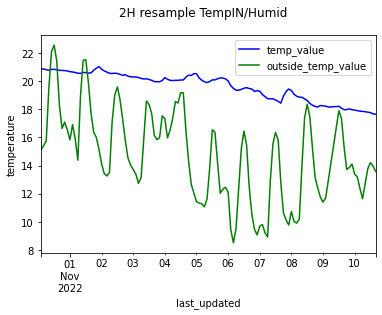

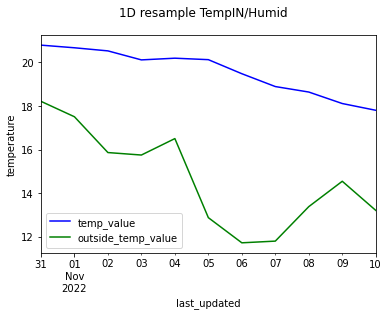

In [8]:
import matplotlib.pyplot as plt
ax1 = df_temp_humid_processed["temp_value"].plot(style='b-')
ax1.legend(loc="lower left")
ax2 = df_temp_humid_processed["outside_temp_value"].plot(style='g-')
ax2.legend(loc="lower left")
ax3 = df_temp_humid_processed["humid_value"].plot(style='r-', secondary_y=True)
ax3.legend(loc="lower left")
ax1.set_ylabel("temperature")
ax2.set_ylabel("humidity")
plt.suptitle("2H resample TempIN/TempOUT/Humid")
plt.show()

ax1 = df_temp_humid_processed["temp_value"].plot(style='b-')
ax1.legend(loc='best')
ax2 = df_temp_humid_processed["outside_temp_value"].plot(style='g-')
ax2.legend(loc='best')
ax1.set_ylabel("temperature")
plt.suptitle("2H resample TempIN/Humid")
plt.savefig("temp_in-temp_out")
plt.show()

ax1 = df_temp_humid_processed["temp_value"].resample("1D").mean().plot(style='b-')
ax1.legend(loc='best')
ax2 = df_temp_humid_processed["outside_temp_value"].resample("1D").mean().plot(style='g-')
ax2.legend(loc='best')
ax1.set_ylabel("temperature")
plt.suptitle("1D resample TempIN/Humid")
plt.show()


### Correlating sensors and presence

In [9]:
import numpy as np
resample_time = "2h"

# Loading the basement sensors
date_column = "last_updated"
value_column = "temp_value"

query = """ 
SELECT last_updated, entity_id, state
FROM states
WHERE entity_id = 'sensor.basement_bed_pht_temperature'
"""
df_temperature = pd.read_sql_query(query, connection)
df_temperature = df_temperature.rename(columns={"state": value_column})
# NB aggregates on resample will drop entity_id column cos not conform to average
df_temperature_processed = process_ha_sensor(df_temperature, date_col=date_column, value_col=value_column, resample_time=resample_time, plot_process=False)
print(f"Temperature:\n {df_temperature_processed.head(2)}\n")

# Mapping to boolean values
date_column = "last_updated"
value_column = "light_value"

query = """ 
SELECT last_updated, entity_id, state
FROM states
WHERE 	entity_id LIKE 'light.basement'
"""
df_lights = pd.read_sql_query(query, connection)
df_lights = df_lights.rename(columns={"state": value_column})

# Logically or in the 10min period -> no best method
df_lights = df_lights.drop(columns=["entity_id"]) # Need to drop cos 'last' work also on entity name
df_lights_processed = process_ha_sensor(df_lights, date_col=date_column, value_col=value_column, value_column_type="string", resample=True, resample_time=resample_time, resample_aggregate_mode='last', interpolate=False) 
mapping = {'on': True, 'off': False}
df_lights_processed[value_column] = df_lights_processed[value_column].map(mapping).fillna(method="ffill")
df_lights_processed[value_column] = df_lights_processed[value_column].astype(bool)
print(f"Light:\n {df_lights_processed.head(2)}\n")

# Merge the sensors
df_temp_light_processed = df_temperature_processed.join(df_lights_processed)
# Set first value to false so then fill forward light state if NaN
df_temp_light_processed.iloc[0, 1] = False
df_temp_light_processed = df_temp_light_processed.fillna(method="ffill")
print(df_temp_light_processed[830:].head(10))

Temperature:
                      temp_value
last_updated                   
2022-10-31 02:00:00   20.865600
2022-10-31 04:00:00   20.857194

Light:
                      light_value
last_updated                    
2022-10-31 18:00:00        False
2022-10-31 20:00:00        False

Empty DataFrame
Columns: [temp_value, light_value]
Index: []


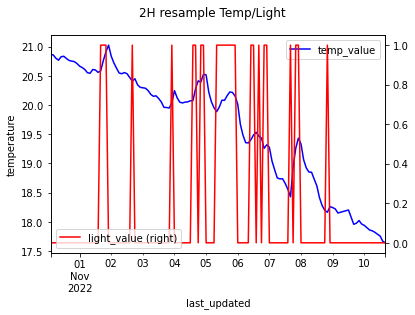

In [10]:
import matplotlib.pyplot as plt
ax1 = df_temp_light_processed["temp_value"].plot(style='b-')
ax1.legend(loc='lower left')
ax3 = df_temp_light_processed["light_value"].astype(float).plot(style='r-', secondary_y=True)
ax3.legend(loc='lower left')
ax1.set_ylabel("temperature")
ax2.set_ylabel("light")
plt.suptitle("2H resample Temp/Light")
plt.savefig("presence-temperature.png")
plt.show()